In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
HOME = expanduser("~")
import os
import SimpleITK as sitk
from PIL import Image, ImageOps
#%matplotlib inline

In [2]:
DIR = os.path.join(HOME, 'programming', 'dk39')
#DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK39'
ORIENTED = os.path.join(DIR, 'preps', 'oriented')
PREALIGNED = os.path.join(DIR, 'preps', 'prealigned')
ALIGNED = os.path.join(DIR, 'preps', 'aligned')
NORMALIZED = os.path.join(DIR, 'preps', 'normalized')
POSTALIGNED = os.path.join(DIR, 'preps', 'postaligned')
PADDED = os.path.join(DIR, 'preps', 'padded')

THUMBNAIL = os.path.join(DIR, 'preps', 'thumbnail')
INPUT = THUMBNAIL
INPUTS = sorted(os.listdir(INPUT))
BADS = ['DK39_ID_0001_slide001_S1_C1.tif', 'DK39_ID_0007_slide001_S2_C1.tif', 'DK39_ID_0010_slide001_S3_C1.tif']
INPUTS = sorted([i for i in INPUTS if i not in BADS and '_C1' in i])

In [3]:
def everything(img, rotation):
    img = get_last_2d(img)
    img = np.rot90(img, rotation)
    img = crop_rows(img, 50)
    return img.astype('uint16')

def get_last_2d(data):
    if data.ndim <= 2:
        return data    
    m,n = data.shape[-2:]
    return data.flat[:m*n].reshape(m,n)

def crop_rows(img,cropy):
    y,x = img.shape
    starty = y - cropy
    return img[0:starty,:]

def lognorm(img, limit):
    lxf = np.log(img + 0.005)
    lxf = np.where(lxf < 0, 0, lxf)
    xmin = min(lxf.flatten())
    xmax = max(lxf.flatten())
    return -lxf * limit / (xmax - xmin) + xmax * limit / (xmax - xmin)  # log of data and stretch 0 to 255


def linnorm(img, limit):
    flat = img.flatten()
    hist, bins = np.histogram(flat, limit + 1)
    cdf = hist.cumsum()  # cumulative distribution function
    cdf = limit * cdf / cdf[-1]  # normalize
    # use linear interpolation of cdf to find new pixel values
    img_norm = np.interp(flat, bins[:-1], cdf)
    img_norm = np.reshape(img_norm, img.shape)
    img_norm = limit - img_norm
    return img_norm.astype('uint16')

def get_max_size(INPUT):
    widths = []
    heights = []
    files = os.listdir(INPUT)
    for file in files:
        img = io.imread(os.path.join(INPUT, file))
        heights.append(img.shape[0])
        widths.append(img.shape[1])

    max_width = max(widths)
    max_height = max(heights)

    return max_width, max_height

In [4]:
# orient images
dels = os.listdir(ORIENTED)
for d in dels:
    os.unlink(os.path.join(ORIENTED, d))

for i in (INPUTS):
    infile = os.path.join(INPUT, i)
    outfile = os.path.join(ORIENTED, i)
    img = io.imread(infile)
    img = everything(img, 3)
    io.imsave(outfile, img, check_contrast=False)
    img = None

In [5]:
# Instantiate SimpleElastix
INPUT = ORIENTED
OUTPUT = PREALIGNED

def create_registration(fixedImage, movingImage, parameterMap, count):
    elastixImageFilter = sitk.ElastixImageFilter()
    # Read Input
    elastixImageFilter.SetFixedImage(sitk.ReadImage( os.path.join(INPUT, fixedImage) ))
    elastixImageFilter.SetMovingImage(sitk.ReadImage( os.path.join(INPUT, movingImage) ))
    elastixImageFilter.SetParameterMap(parameterMap)
    # Perform registration
    #elastixImageFilter.LogToConsoleOn()
    elastixImageFilter.Execute()
    filename = '{}.tif'.format(str(count).zfill(4))
    outfile = os.path.join(OUTPUT, filename)
    #elastixImageFilter.WriteImage(elastixImageFilter.GetResultImage(), outfile )
    sitk.WriteImage(elastixImageFilter.GetResultImage(), outfile)

    return elastixImageFilter.GetParameterMap() 

In [6]:
# try aligning with itself
p = sitk.GetDefaultParameterMap("rigid")
p["Transform"] = ["AffineTransform"]

dels = os.listdir(OUTPUT)
for d in dels:
    os.unlink(os.path.join(OUTPUT, d))

files = sorted(os.listdir(INPUT))
stop = len(files) - 1
files.insert(0, files[0])
for i, file in enumerate(files):
    if i == stop:
        break
    if i == 0:
        parameterMap = p
        parameterMap = create_registration(files[i], files[i+1], p, i)
    else:
        parameterMap = create_registration(files[i], files[i+1], parameterMap, i)

In [7]:
# C0, counter stain, C1 red, C2 green - scaled sized tifs
INPUT = PREALIGNED
OUTPUT = ALIGNED
INPUTS = sorted(os.listdir(INPUT))
OUTPUTS = sorted(os.listdir(OUTPUT))

In [8]:
# fix
dels = os.listdir(OUTPUT)
for d in dels:
    os.unlink(os.path.join(OUTPUT, d))

img_outputs = []
file_inputs = []
for file in INPUTS:    
    infile = os.path.join(INPUT, file)
    outfile = os.path.join(OUTPUT, file)
    img = io.imread(infile)
    file_inputs.append(file)
    flat = img.flatten()
    fmax = int(flat.max())
    fmin = int(flat.min())
    flat = flat + abs(fmin)
    img = np.reshape(flat, img.shape)    
    img_outputs.append(img)
    io.imsave(outfile, img.astype('uint16'), check_contrast=False)
    img = None
print('done')

done


In [9]:
# pad
INPUT = ALIGNED
OUTPUT = PADDED
INPUTS = sorted(os.listdir(INPUT))
max_width, max_height = get_max_size(INPUT)
print(max_width, max_height)

1565 937


In [10]:
dels = os.listdir(OUTPUT)
for d in dels:
    os.unlink(os.path.join(OUTPUT, d))

img_outputs = []
zmidr = max_height // 2
zmidc = max_width // 2

for file in INPUTS:    
    infile = os.path.join(INPUT, file)
    outfile = os.path.join(OUTPUT, file)
    img = io.imread(infile)
    startr = zmidr - (img.shape[0] // 2)
    endr = startr + img.shape[0]
    startc = zmidc - (img.shape[1] // 2)
    endc = startc + img.shape[1]
    new_img = np.zeros([max_height, max_width])
    new_img[startr:endr,startc:endc] = img
    
    
    img_outputs.append(new_img)
    io.imsave(outfile, new_img.astype('uint16'), check_contrast=False)
    img = None
    new_img = None
print('done')

done


In [11]:
INPUT = PADDED
INPUTS = sorted(os.listdir(INPUT))
img_inputs = []
file_inputs = []
for file in INPUTS:    
    infile = os.path.join(INPUT, file)
    img = io.imread(infile)
    file_inputs.append(file)
    img_inputs.append(img)
    img = None
print('done')

done


In [12]:
len(img_inputs)

137

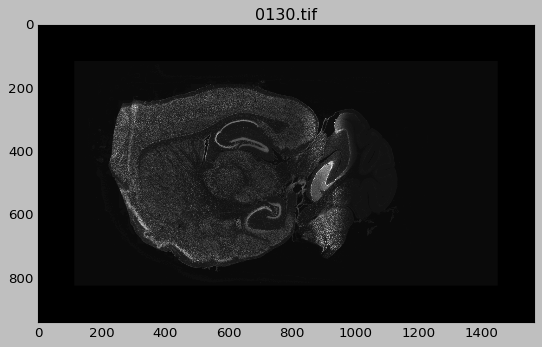

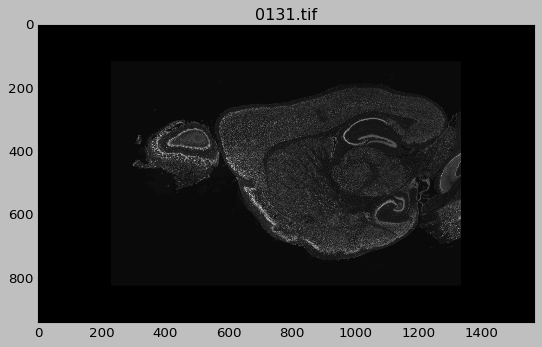

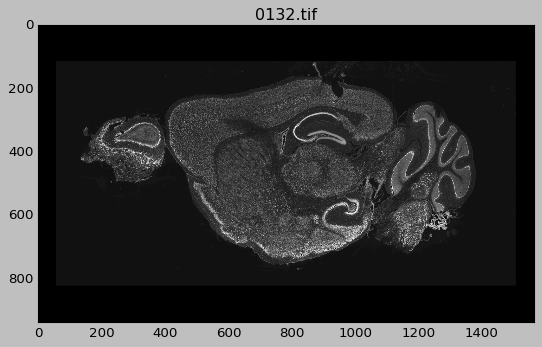

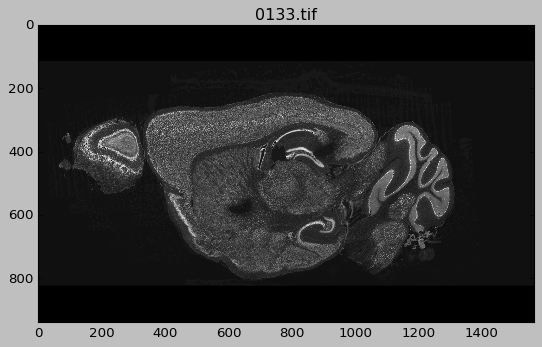

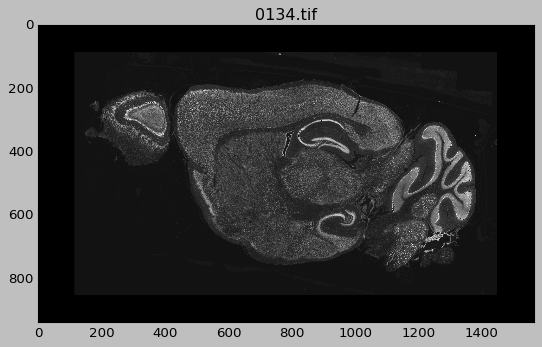

In [17]:
# display images
# check alignment
start, finish = (130,135)
files = img_inputs[start:finish]
names = file_inputs[start:finish]
plt.style.use('classic')
for name,img in zip(names,files):    
    plt.figure()
    plt.title(name)
    plt.imshow(img, cmap='gray')
    plt.show()

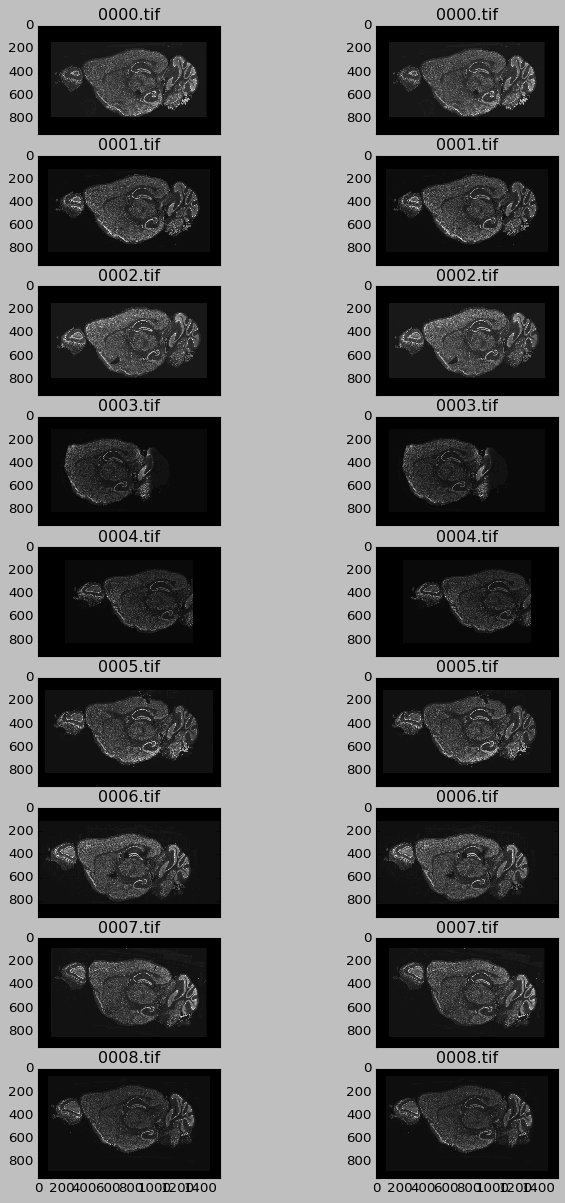

In [14]:
# display images
start, finish = (-10,-1)
original = img_inputs[start:finish]
aligned = img_outputs[start:finish]
rows = len(original)
fig, ax = plt.subplots(nrows=rows, ncols=2, sharex=True, figsize=(10, 18))
#plt.style.use('classic')
#plt.rcParams.update({'figure.figsize': [10,12]})
i = 0
for old, new, filename in zip(original, aligned, file_inputs):
    ax[i,0].set_title(filename)
    ax[i,0].imshow(old, cmap='gray')

    ax[i,1].set_title(filename)
    ax[i,1].imshow(new, cmap='gray')
    i += 1


0010.tif


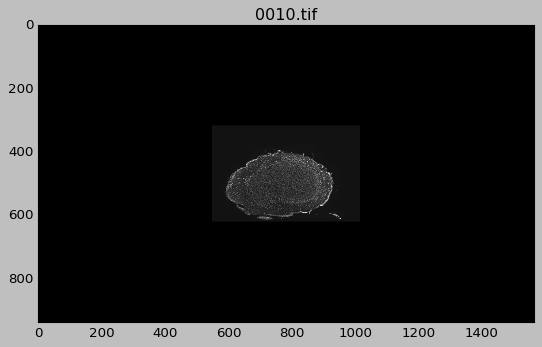

In [15]:
print(file_inputs[10])
plt.figure()
plt.rcParams.update({'figure.figsize': [10, 6]})
plt.title(file_inputs[10])
plt.imshow(img_outputs[10], cmap='gray')
plt.show()